# torch: Training Neural Networks for Classification and Dimensionality Reduction

This notebook demonstrates example neural network setups for **image classification** and **dimensionality reduction** tasks using `torch`.

The examples serve as complement and comparison for exploring neural networks with the `edu.yaprnn` app.

Loading MNIST images from E:\edu.yaprnn\src\main\resources\digits.idx3-ubyte


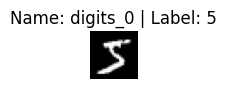

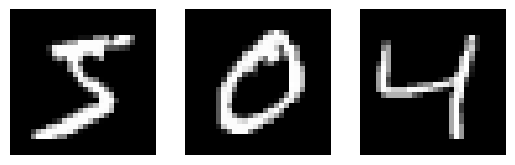

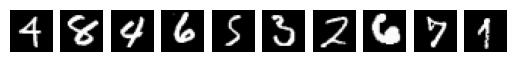

(36000, 784) (36000, 10) (36000,) (12000, 784) (12000, 10) (12000,)
(48000, 784) (48000, 10) (48000,) (12000, 784) (12000, 10) (12000,)
(48000, 784) (48000, 10) (48000,) (12000, 784) (12000, 10) (12000,)


In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

import mnist_utils

mnist_images, image_size, X, random_x_indices, random_feature_indices, y, labels = mnist_utils.from_mnist_images()

digits_train_32k_test_12k = train_test_split(X, y, labels, train_size=0.6, test_size=0.2, random_state=42)
digits_images_from_labels = train_test_split(X, y, labels, train_size=0.8, test_size=0.2, random_state=42)
digits_input_reconstruction = train_test_split(X, y, labels, train_size=0.8, test_size=0.2, random_state=42)

mnist_utils.from_dataset(digits_train_32k_test_12k, explain=True)
mnist_utils.from_dataset(digits_images_from_labels, explain=True)
mnist_utils.from_dataset(digits_input_reconstruction, explain=True)

None

In [2]:
import torch
from sklearn.metrics import accuracy_score
from torch.nn import Sequential, Linear, GELU, MSELoss
from torch.optim import SGD, AdamW
from torch.utils.data import DataLoader, TensorDataset


def to_tensor(x):
    return torch.tensor(x, dtype=torch.float32).to(device)


def count_parameters(_model):
    return sum(p.numel() for p in _model.parameters() if p.requires_grad)


def calculate_accuracy(_model, x_tensor, y):
    with torch.no_grad():
        outputs = _model.forward(x_tensor)
        _, _predictions_tensor = torch.max(outputs, dim=1)
        y_true = np.argmax(y, axis=1)
        y_pred = _predictions_tensor.cpu().numpy()
        return accuracy_score(y_true, y_pred)


def train_model(_model, _epochs, _train_loader, _criterion, _optimizer):
    _model.train()
    for epoch in range(_epochs):
        loss = None
        for batch_X_tensor, batch_y_tensor in _train_loader:
            _optimizer.zero_grad()
            output_tensor = _model.forward(batch_X_tensor)
            loss = _criterion(output_tensor, batch_y_tensor)
            loss.backward()
            _optimizer.step()
        if loss is not None:
            print(f'Epoch {epoch + 1}/{_epochs}, Loss: {loss.item():.4f}')


device_type = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_type)
print(f'Using device: {device}')

preferred_batch_size = 31 * (4 if device_type == 'cuda' else 1)
preferred_learning_rate = 0.02 / preferred_batch_size

Using device: cuda


## Digits Classification

This model is configured as follows:

- **Architecture**:
  - Input layer: 784 neurons
  - 2 hidden layers:
    - Layer 1: 20 neurons
    - Layer 2: 15 neurons
  - Output layer: 10 neurons
  - Total parameters: `((784 + 1) * 20) + ((20 + 1) * 15) + ((15 + 1) * 10) = 16175` (Biases included)
- **Activation Function**:
  - gelu
- **Optimizer**: Stochastic Gradient Descent (SGD)
  - Learning rate: 0.02
  - Momentum: 0.2 with Nesterov term
  - L2-weight-decay: 0.001
- **Loss Function**: Mean Squared Error (MSE)

In [3]:
input_size, output_size, X_train, y_train, X_test, y_test = mnist_utils.from_dataset(digits_train_32k_test_12k)
X_train_tensor = to_tensor(X_train)
y_train_tensor = to_tensor(y_train)
X_test_tensor = to_tensor(X_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=preferred_batch_size, shuffle=True)

model = Sequential(
    Linear(input_size, 20),
    GELU(),
    Linear(20, 15),
    GELU(),
    Linear(15, output_size),
    GELU()
)
model.to(device)

optimizer = SGD(model.parameters(), lr=preferred_learning_rate, momentum=0.2, nesterov=True, weight_decay=0.001)
optimizer = AdamW(model.parameters(), lr=preferred_learning_rate, weight_decay=0.001)

train_model(model, _epochs=50, _train_loader=train_loader, _criterion=MSELoss(), _optimizer=optimizer)

print(f'Actual number of parameters: {count_parameters(model)}')

Epoch 1/50, Loss: 0.0585
Epoch 2/50, Loss: 0.0457
Epoch 3/50, Loss: 0.0319
Epoch 4/50, Loss: 0.0353
Epoch 5/50, Loss: 0.0318
Epoch 6/50, Loss: 0.0344
Epoch 7/50, Loss: 0.0274
Epoch 8/50, Loss: 0.0264
Epoch 9/50, Loss: 0.0239
Epoch 10/50, Loss: 0.0224
Epoch 11/50, Loss: 0.0179
Epoch 12/50, Loss: 0.0278
Epoch 13/50, Loss: 0.0194
Epoch 14/50, Loss: 0.0161
Epoch 15/50, Loss: 0.0160
Epoch 16/50, Loss: 0.0211
Epoch 17/50, Loss: 0.0182
Epoch 18/50, Loss: 0.0173
Epoch 19/50, Loss: 0.0150
Epoch 20/50, Loss: 0.0198
Epoch 21/50, Loss: 0.0158
Epoch 22/50, Loss: 0.0182
Epoch 23/50, Loss: 0.0130
Epoch 24/50, Loss: 0.0117
Epoch 25/50, Loss: 0.0114
Epoch 26/50, Loss: 0.0166
Epoch 27/50, Loss: 0.0246
Epoch 28/50, Loss: 0.0101
Epoch 29/50, Loss: 0.0117
Epoch 30/50, Loss: 0.0143
Epoch 31/50, Loss: 0.0141
Epoch 32/50, Loss: 0.0160
Epoch 33/50, Loss: 0.0121
Epoch 34/50, Loss: 0.0172
Epoch 35/50, Loss: 0.0182
Epoch 36/50, Loss: 0.0115
Epoch 37/50, Loss: 0.0248
Epoch 38/50, Loss: 0.0153
Epoch 39/50, Loss: 0.

In [4]:
model.eval()
print(f'Accuracy on training set: {calculate_accuracy(model, X_train_tensor, y_train)}')
print(f'Accuracy on test set: {calculate_accuracy(model, X_test_tensor, y_test)}')

random_test_indices = np.random.choice(X_test.shape[0], 5, replace=False)
with torch.no_grad():
    input_tensor = to_tensor(X_test[random_test_indices])
    predicted = model.forward(input_tensor).cpu().numpy()
print(np.argmax(predicted, axis=1))
predicted.round(2).astype('str')

Accuracy on training set: 0.9500555555555555
Accuracy on test set: 0.94025
[1 5 5 2 1]


array([['-0.01', '1.1', '-0.13', '-0.07', '-0.02', '-0.04', '-0.02',
        '0.01', '0.12', '0.0'],
       ['-0.02', '-0.01', '-0.05', '0.01', '-0.07', '1.16', '-0.03',
        '-0.05', '-0.1', '0.02'],
       ['-0.01', '0.0', '-0.01', '-0.13', '-0.01', '1.12', '-0.04',
        '-0.05', '0.08', '-0.01'],
       ['0.0', '0.0', '1.25', '-0.11', '-0.01', '0.03', '-0.07', '-0.01',
        '-0.16', '0.01'],
       ['0.0', '1.04', '-0.01', '-0.01', '-0.01', '0.02', '0.0', '-0.02',
        '-0.0', '-0.03']], dtype='<U32')

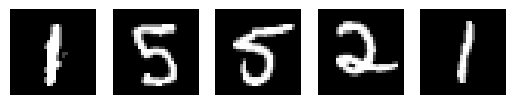

[1 5 5 2 1]


array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

In [5]:
mnist_utils.plot_images(X_test[random_test_indices], image_size=image_size, cmap='gray')
print(np.argmax(y_test[random_test_indices], axis=1))
y_test[random_test_indices]

## Dimensionality Reduction with an Autoencoder

This section demonstrates the use of two neural networks for dimensionality reduction. These networks rely on a bottleneck layer in their architecture to reduce the input data's dimensionality.

Instead of using predefined methods to extract the most relevant features, the networks are trained using backpropagation. This approach enables the model to automatically learn a transformation into a compressed feature space along with its inverse transformation to reconstruct the input data as accurately as possible.

### Shallow Autoencoder Network with 12 Neurons Bottleneck Layer

This model is configured as follows:

- **Architecture**:
  - Input layer: 784 neurons
  - 5 hidden layers:
    - Layer 1: 196 neurons
    - Layer 2: 49 neurons
    - Layer 3: 12 neurons
    - Layer 4: 49 neurons
    - Layer 5: 196 neurons
  - Output layer: 784 neurons
  - Total parameters: 328998 (Biases included)
- **Activation Function**: Gaussian Error Linear Unit (GeLU)
- **Optimizer**: Stochastic Gradient Descent (SGD)
  - Learning rate: 0.02
  - Momentum: 0.2 with Nesterov term
  - L2-weight-decay: 0.001
- **Loss Function**: Mean Squared Error (MSE)

In [6]:
input_size, output_size, X_train, _, X_test, _ = mnist_utils.from_dataset(digits_input_reconstruction)
X_train_tensor = to_tensor(X_train)
X_test_tensor = to_tensor(X_test)

train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=preferred_batch_size, shuffle=True)

model = Sequential(
    Linear(input_size, 196),
    GELU(),
    Linear(196, 49),
    GELU(),
    Linear(49, 12),
    GELU(),
    Linear(12, 49),
    GELU(),
    Linear(49, 196),
    GELU(),
    Linear(196, input_size),
    GELU()
)
model.to(device)

optimizer = SGD(model.parameters(), lr=preferred_learning_rate, momentum=0.2, nesterov=True, weight_decay=0.001)
optimizer = AdamW(model.parameters(), lr=preferred_learning_rate, weight_decay=0.001)

train_model(model, _epochs=100, _train_loader=train_loader, _criterion=MSELoss(), _optimizer=optimizer)

print(f'Actual number of parameters: {count_parameters(model)}')

Epoch 1/100, Loss: 0.0468
Epoch 2/100, Loss: 0.0424
Epoch 3/100, Loss: 0.0319
Epoch 4/100, Loss: 0.0328
Epoch 5/100, Loss: 0.0298
Epoch 6/100, Loss: 0.0286
Epoch 7/100, Loss: 0.0191
Epoch 8/100, Loss: 0.0301
Epoch 9/100, Loss: 0.0213
Epoch 10/100, Loss: 0.0253
Epoch 11/100, Loss: 0.0194
Epoch 12/100, Loss: 0.0211
Epoch 13/100, Loss: 0.0288
Epoch 14/100, Loss: 0.0227
Epoch 15/100, Loss: 0.0263
Epoch 16/100, Loss: 0.0160
Epoch 17/100, Loss: 0.0181
Epoch 18/100, Loss: 0.0190
Epoch 19/100, Loss: 0.0233
Epoch 20/100, Loss: 0.0246
Epoch 21/100, Loss: 0.0174
Epoch 22/100, Loss: 0.0229
Epoch 23/100, Loss: 0.0244
Epoch 24/100, Loss: 0.0229
Epoch 25/100, Loss: 0.0209
Epoch 26/100, Loss: 0.0205
Epoch 27/100, Loss: 0.0176
Epoch 28/100, Loss: 0.0234
Epoch 29/100, Loss: 0.0156
Epoch 30/100, Loss: 0.0202
Epoch 31/100, Loss: 0.0162
Epoch 32/100, Loss: 0.0212
Epoch 33/100, Loss: 0.0186
Epoch 34/100, Loss: 0.0228
Epoch 35/100, Loss: 0.0145
Epoch 36/100, Loss: 0.0223
Epoch 37/100, Loss: 0.0201
Epoch 38/1

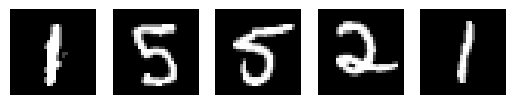

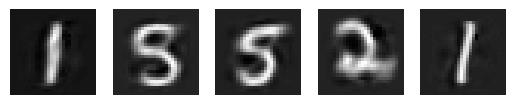

In [7]:
original = X_test[random_test_indices]
mnist_utils.plot_images(original, image_size=image_size, cmap='gray')

#print(f'Score X_train: {model.score(X_train, X_train)}')
#print(f'Score X_test: {model.score(X_test, X_test)}', )
with torch.no_grad():
    output_tensor = model.forward(to_tensor(original))
    restored = output_tensor.cpu().numpy()
mnist_utils.plot_images(restored, image_size=image_size, cmap='gray')